<a href="https://colab.research.google.com/github/EngIyasu/GLDAS_for_Monitoring_Water_Budgets/blob/master/GLDAS2_1_for_Monitoring_Water_Budgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Water Budget Estimation using Global Land Data Assimilation Model

This Python Notebook investigate and compare wet and dry season water budget components from Global Land Data Assimilation Model (GLDAS) Version 2.1 for the Limpopo River Basin in South Africa ([NASA's Applied Remote Sensing Training (ARSET)](https://arset.gsfc.nasa.gov/water/webinars/water-budgets-river-basin); [Water Budget Estimation using GLDAS Model](https://arset.gsfc.nasa.gov/sites/default/files/water/20-WaterBudgets-RiverBasins/Exercise3-GLDAS_Final.pdf)). It also estimate seasonal, basin-averaged, and sub-basin level water budget components.

### Required Packages

In [1]:
!pip install geopandas
!pip install rasterio
!pip install earthpy

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install rasterstats
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756173 sha256=06f39b84ad7f7bddb0edff3183f778f965ebfbb7bcde2b5fcc4be0a5d1a3b754
  Stored in directory: /tmp/pip-ephem-wheel-cache-flmx1u8g/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [2]:
%matplotlib inline
import os
import time
import geopandas as gpd
from glob import glob
import rasterio as rio
import earthpy.spatial as es
from json import dumps
import folium
from pathlib import Path
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterstats import zonal_stats
from selenium import webdriver
from IPython.display import display, Image

### List of Abbreviations
- GLDAS: Global Land Data Assimilation System 
- PR: Precipitation
- ET: Evapotranspiration
- TWS: Total Water Storage
- DTWS: Difference Total Water Storage
- RO: Runoff
- BRO: Base Runoff
- W: Wet
- D: Dry
- BCM: Billions of Cubic Meters
- sqm: Square Meter
- cum: Cubic Meter

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Setting Working Directory in Google Drive Folder

In [4]:
os.chdir("/content/gdrive/My Drive/Part_03_NASA_ARSET")

### Limpopo River Basin Shapefile
#### Reading shapefile and converting shp to geojson

In [5]:
# Reading shapefile as geopandas
gpd_shapefile = gpd.read_file("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp")

# Writing geopandas as geojson
gpd_shapefile.to_file("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.json", driver="GeoJSON")

In [6]:
bbox_extent = gpd_shapefile.total_bounds
lon_center, lat_center = np.array(bbox_extent).reshape(2, 2).mean(axis=0)

my_map = folium.Map(location=[lat_center, lon_center],tiles='Stamen Terrain',zoom_start=7.0)

folium.GeoJson(
    './data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.json',
    name='Limpopo River Basin',
    style_function=lambda feature: {
        'fillColor': 'None',
        'color' : 'blue',
        'weight' : 5,
    }
).add_to(my_map)
my_map

In [7]:
## Saving map
my_map.save('./data/Limpopo_River_Basin.html')

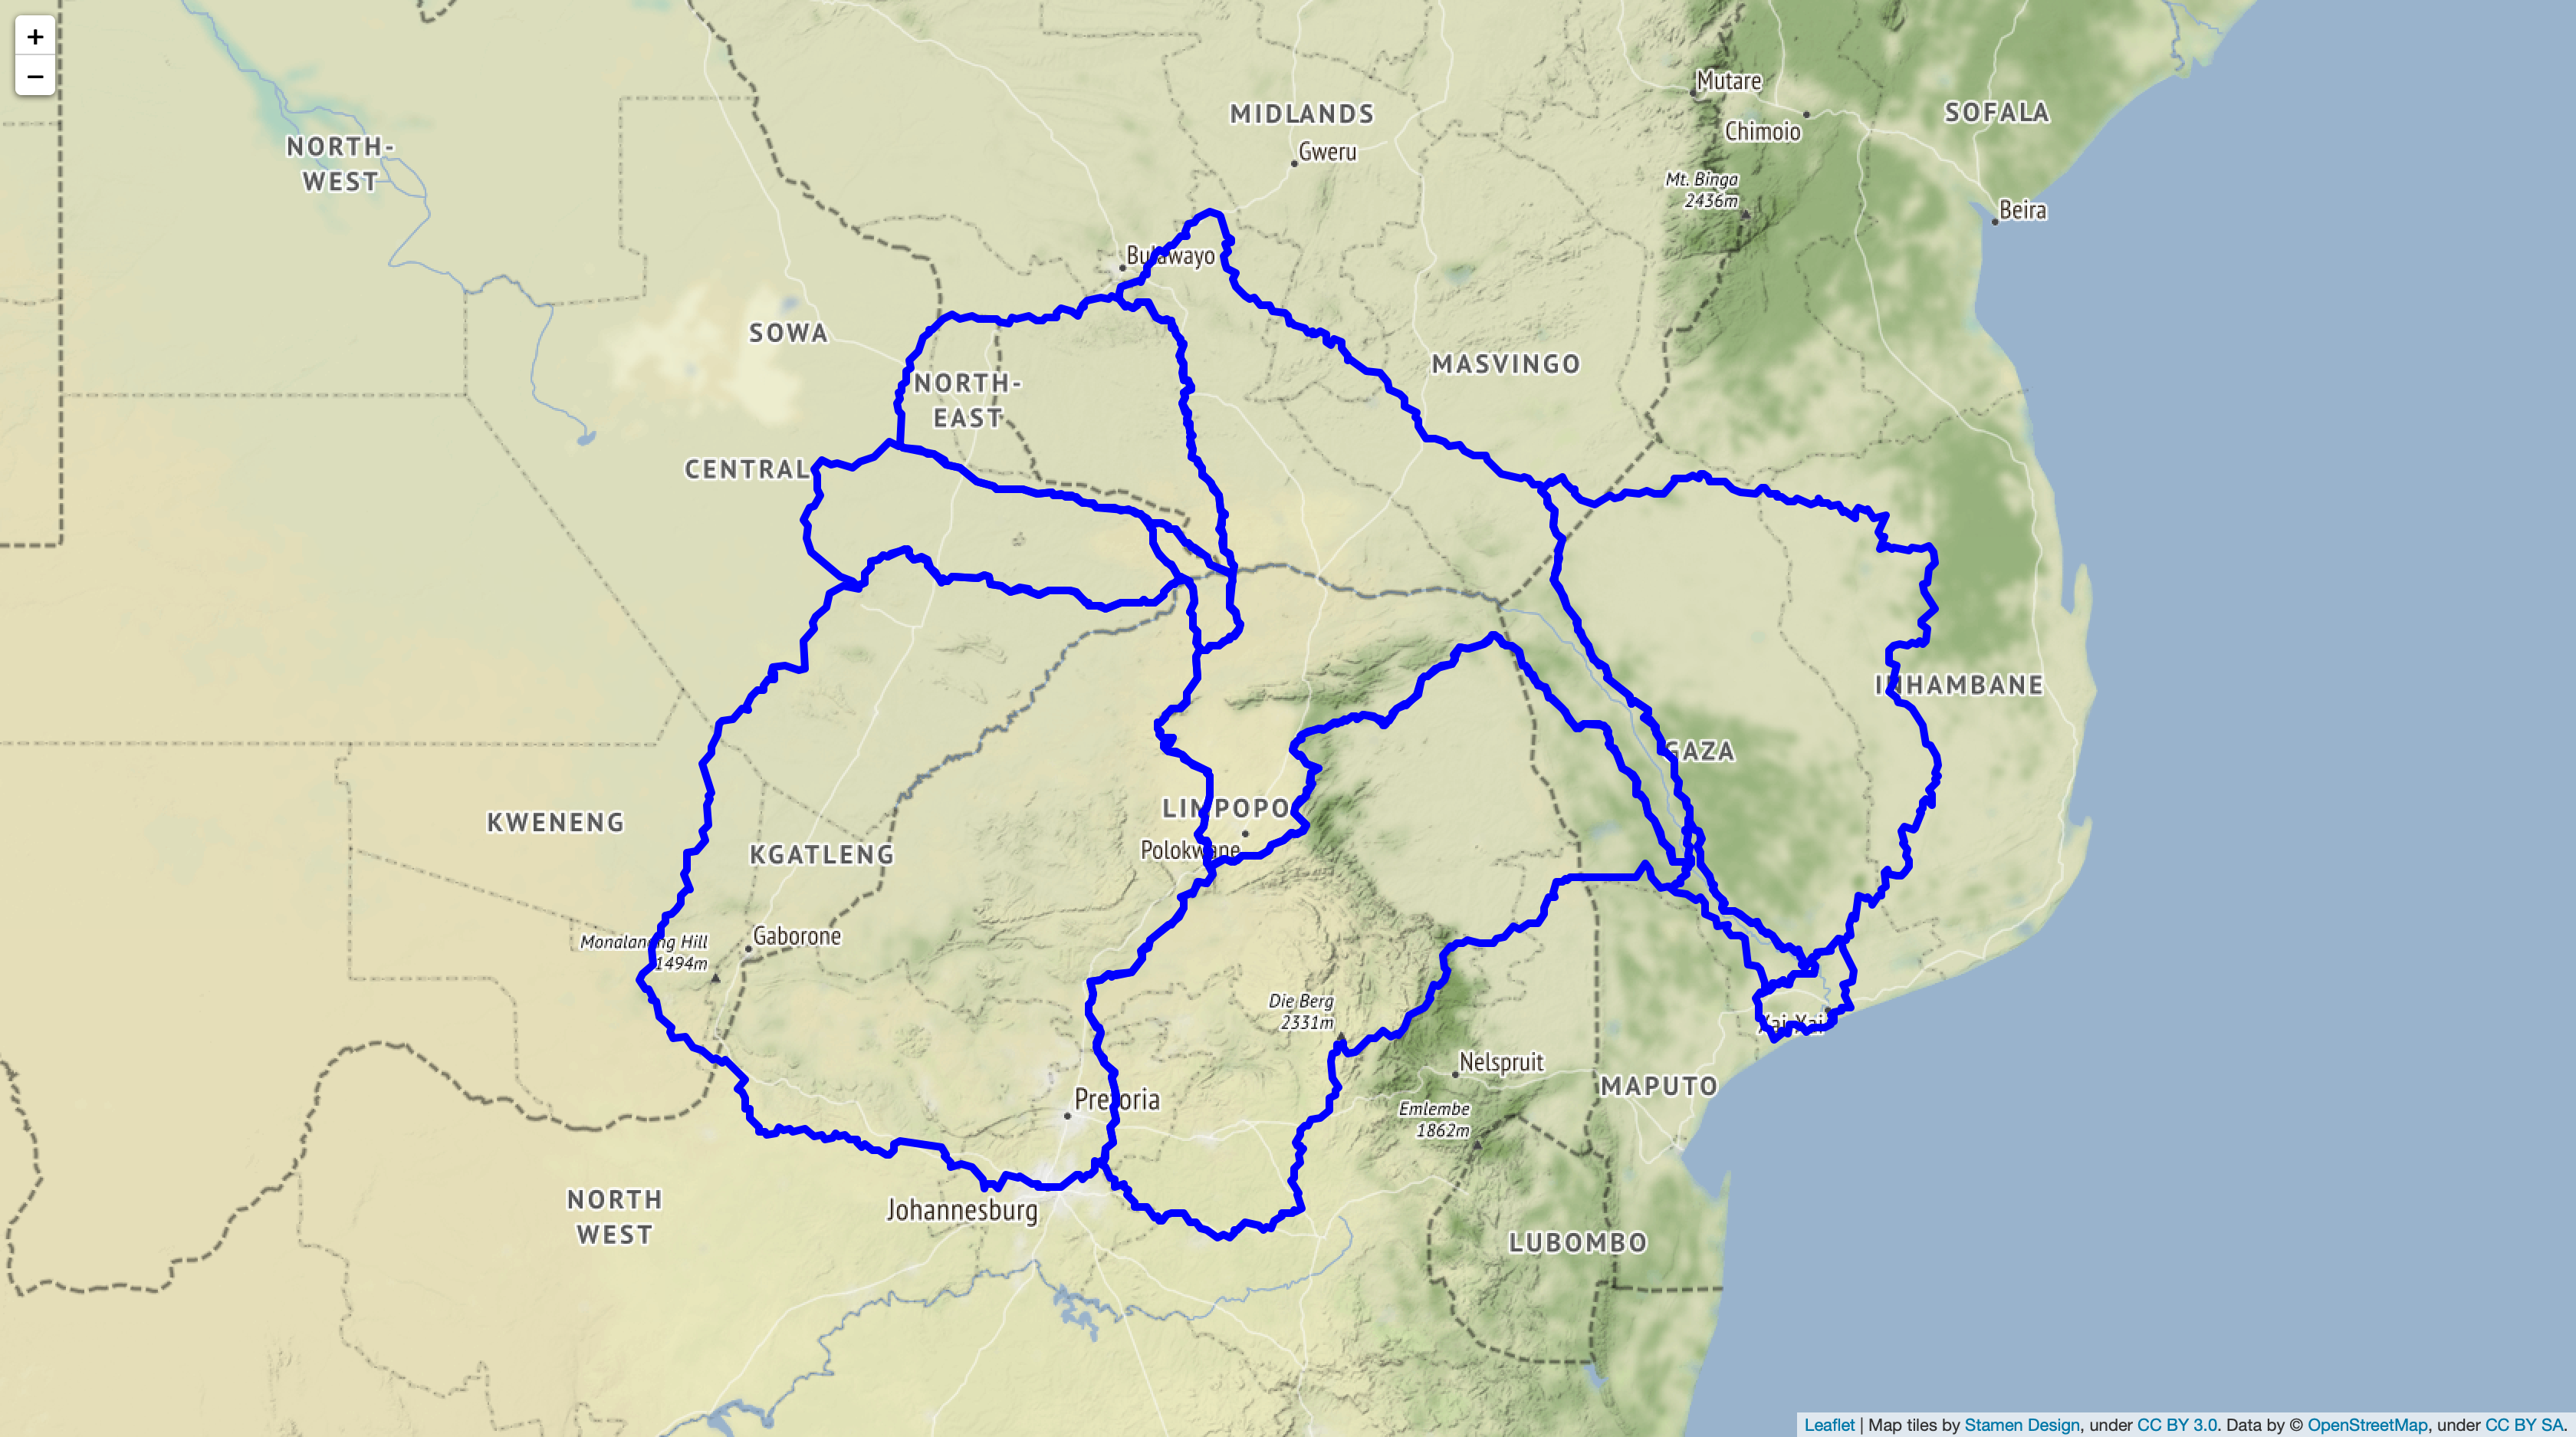

In [8]:
Image('./data/Limpopo_River_Basin.png', width=1200)

### 1. Precipitation

In [9]:
PR_files = sorted([i for i in glob('./data/GLDAS_PR/*.{}'.format('tif'))])

#### Wet Season

In [10]:
PR_files_wet = list(map(PR_files.__getitem__, [1,3,2]))
PR_wet = np.empty((8, 10,3))
PR_wet[:] = np.nan
for i in range(3):
  dataset = rio.open(PR_files_wet[i])
  # Grab limits of image's extent
  left, bottom, right, top =  dataset.bounds
  # load the geotiff image, assign it a variable
  image = dataset.read(1)
  image[(image == -9999)] = np.nan
  if i == 0 or i == 1:
    month_days = 31
  else:
    month_days = 28
  image_mm = image * 3600 * 24 * month_days
  PR_wet[:,:,i] = image_mm
  del image_mm
PR_wet19 = np.sum(PR_wet,axis = 2)

#### Dry Season

In [11]:
PR_files_dry = list(map(PR_files.__getitem__, [-1,-2,0]))
PR_dry = np.empty((8, 10,3))
PR_dry[:] = np.nan
for i in range(3):
  dataset = rio.open(PR_files_dry[i])
  # Grab limits of image's extent
  left, bottom, right, top =  dataset.bounds
  # load the geotiff image, assign it a variable
  image = dataset.read(1)
  image[(image == -9999)] = np.nan
  if i == 0:
    month_days = 30
  else:
    month_days = 31
  image_mm = image * 3600 * 24 * month_days
  PR_dry[:,:,i] = image_mm
  del image_mm
PR_dry19 = np.sum(PR_dry,axis = 2)

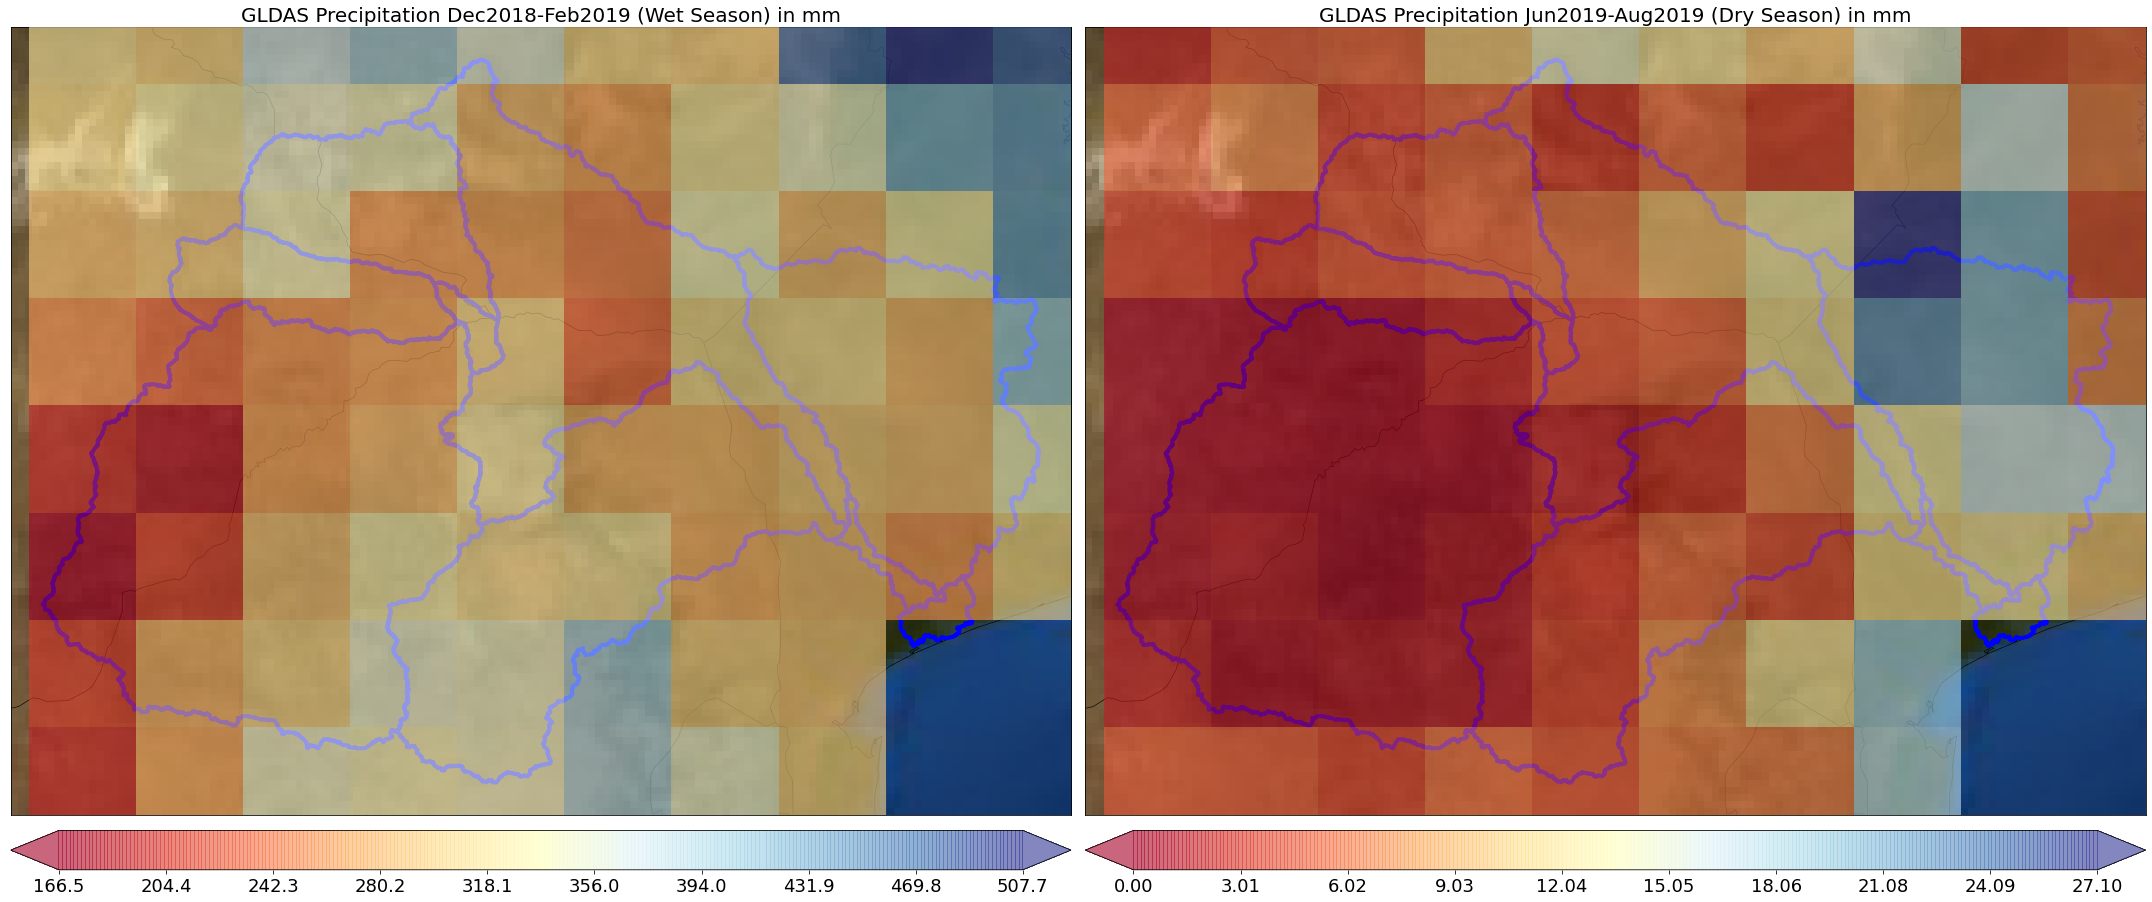

In [12]:
fig, axes = plt.subplots(1,2, figsize=(30,20))#(width,height)
fig.subplots_adjust(hspace=0, wspace=0.02)
axes = axes.ravel()

for i, ax in enumerate(axes):

  if i == 0:
    vmin = np.nanmin(PR_wet19)
    vmax = np.nanmax(PR_wet19)
    data_plot = ma.masked_where(PR_wet19 == np.nan, PR_wet19)
    title_name = 'GLDAS Precipitation Dec2018-Feb2019 (Wet Season) in mm'
  elif i == 1:
    vmin = np.nanmin(PR_dry19)
    vmax = np.nanmax(PR_dry19)
    data_plot = ma.masked_where(PR_dry19 == np.nan, PR_dry19)
    title_name = 'GLDAS Precipitation Jun2019-Aug2019 (Dry Season) in mm'  

  n_add = 0.3 # for zooming in and out
  m = Basemap(ax = axes[i],llcrnrlon=bbox_extent[0]-n_add,llcrnrlat=bbox_extent[1]-n_add,urcrnrlon=bbox_extent[2]+n_add,\
            urcrnrlat=bbox_extent[3]+n_add,resolution='i', projection='cyl')
  m.bluemarble()
  m.drawcoastlines(color='black',linewidth=0.6)
  m.drawcountries(color='black',linewidth=0.6)
  m.drawstates(color='black',linewidth=0.2)   

  im = axes[i].imshow(data_plot, extent=(left, right, bottom, top),vmin=vmin, vmax=vmax,cmap = 'RdYlBu', zorder=10, alpha=0.6)
  m.readshapefile('./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04', \
                'Limpopo_River_Sub-basins_lev04',linewidth=4, color='b',drawbounds=True)
  ax.set_title(title_name,fontsize=20) 
  
  divider = make_axes_locatable(ax)
  ticks = np.linspace(vmin, vmax, 10)
  cax = divider.append_axes("bottom", size="5%", pad="2%")
  cb = fig.colorbar(im, ax=ax,extend='both', cax=cax, orientation="horizontal",ticks=ticks)
  cb.ax.tick_params(labelsize=18)
    
plt.tight_layout()  
plt.savefig('./output/fig_01_GLDAS_Precipitation_Wet_Dry.png',dpi=50,bbox_inches='tight')
plt.show()

### 2. Evapotranspiration

In [13]:
ET_files = sorted([i for i in glob('./data/GLDAS_ET/*.{}'.format('tif'))])

#### Wet Season

In [14]:
ET_files_wet = list(map(ET_files.__getitem__, [1,3,2]))
ET_files_wet = list(map(ET_files.__getitem__, [1,3,2]))
ET_wet = np.empty((8, 10,3))
ET_wet[:] = np.nan
for i in range(3):
  dataset = rio.open(ET_files_wet[i])
  # Grab limits of image's extent
  left, bottom, right, top =  dataset.bounds
  # load the geotiff image, assign it a variable
  image = dataset.read(1)
  image[(image == -9999)] = np.nan
  if i == 0 or i == 1:
    month_days = 31
  else:
    month_days = 28
  image_mm = image * 3600 * 24 * month_days
  ET_wet[:,:,i] = image_mm
  del image_mm
ET_wet19 = np.sum(ET_wet,axis = 2)

#### Dry Season

In [15]:
ET_files_dry = list(map(ET_files.__getitem__, [-1,-2,0]))
ET_dry = np.empty((8, 10,3))
ET_dry[:] = np.nan
for i in range(3):
  dataset = rio.open(ET_files_dry[i])
  # Grab limits of image's extent
  left, bottom, right, top =  dataset.bounds
  # load the geotiff image, assign it a variable
  image = dataset.read(1)
  image[(image == -9999)] = np.nan
  if i == 0:
    month_days = 30
  else:
    month_days = 31
  image_mm = image * 3600 * 24 * month_days
  ET_dry[:,:,i] = image_mm
  del image_mm
ET_dry19 = np.sum(ET_dry,axis = 2)

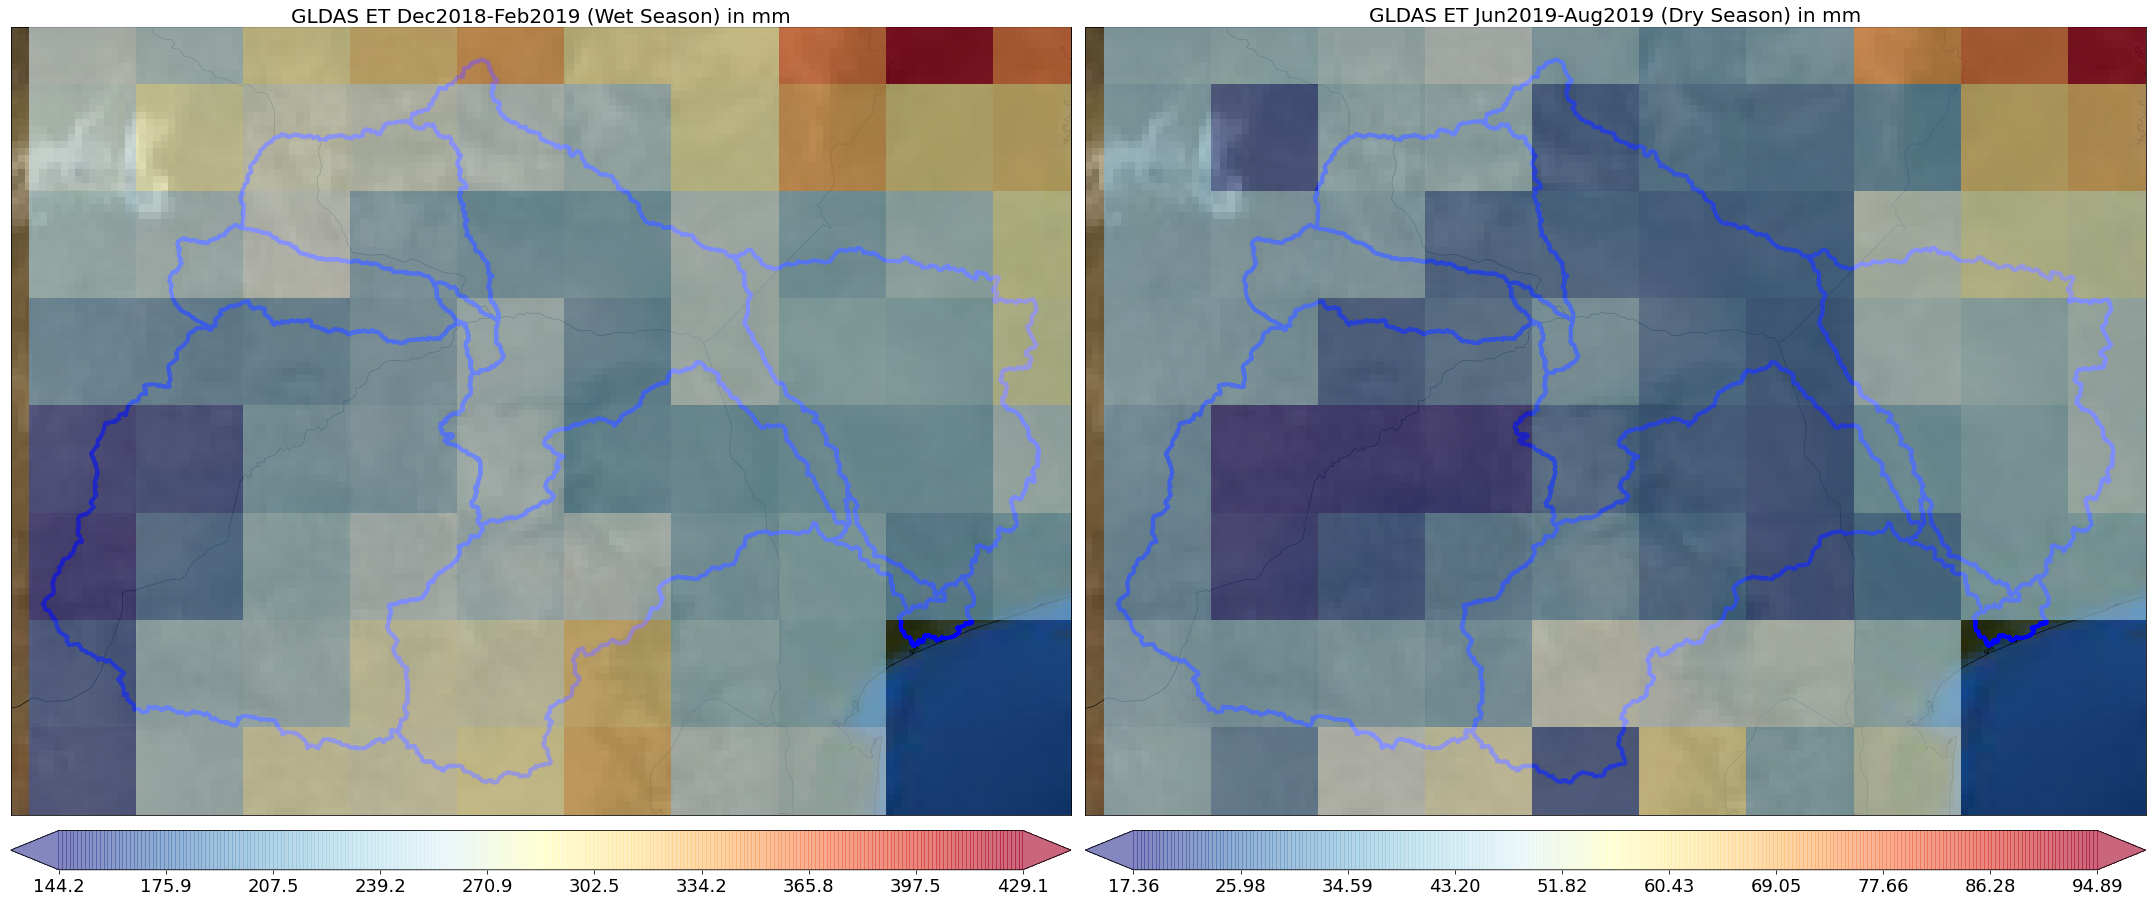

In [16]:
fig, axes = plt.subplots(1,2, figsize=(30,20))#(width,height)
fig.subplots_adjust(hspace=0, wspace=0.02)
axes = axes.ravel()

for i, ax in enumerate(axes):

  if i == 0:
    vmin = np.nanmin(ET_wet19)
    vmax = np.nanmax(ET_wet19)
    data_plot = ma.masked_where(ET_wet19 == np.nan, ET_wet19)
    title_name = 'GLDAS ET Dec2018-Feb2019 (Wet Season) in mm'
  elif i == 1:
    vmin = np.nanmin(ET_dry19)
    vmax = np.nanmax(ET_dry19)
    data_plot = ma.masked_where(ET_dry19 == np.nan, ET_dry19)
    title_name = 'GLDAS ET Jun2019-Aug2019 (Dry Season) in mm'  

  n_add = 0.3 # for zooming in and out
  m = Basemap(ax = axes[i],llcrnrlon=bbox_extent[0]-n_add,llcrnrlat=bbox_extent[1]-n_add,urcrnrlon=bbox_extent[2]+n_add,\
            urcrnrlat=bbox_extent[3]+n_add,resolution='i', projection='cyl')
  m.bluemarble()
  m.drawcoastlines(color='black',linewidth=0.6)
  m.drawcountries(color='black',linewidth=0.6)
  m.drawstates(color='black',linewidth=0.2)   

  im = axes[i].imshow(data_plot, extent=(left, right, bottom, top),vmin=vmin, vmax=vmax,cmap = 'RdYlBu_r', zorder=10, alpha=0.6)
  m.readshapefile('./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04', \
                'Limpopo_River_Sub-basins_lev04',linewidth=4, color='b',drawbounds=True)
  ax.set_title(title_name,fontsize=20) 
  
  divider = make_axes_locatable(ax)
  ticks = np.linspace(vmin, vmax, 10)
  cax = divider.append_axes("bottom", size="5%", pad="2%")
  cb = fig.colorbar(im, ax=ax,extend='both', cax=cax, orientation="horizontal",ticks=ticks)
  cb.ax.tick_params(labelsize=18)
    
plt.tight_layout()  
plt.savefig('./output/fig_01_GLDAS_ET_Wet_Dry.png',dpi=50,bbox_inches='tight')
plt.show()

### 3. Total Waster Storage (TWS)

In [17]:
TWS_files = sorted([i for i in glob('./data/GLDAS_TWS/*.{}'.format('tif'))])

#### Wet Season

In [18]:
## March 2019
dataset_Mar19 = rio.open(TWS_files[2])
# Grab limits of image's extent
left, bottom, right, top =  dataset_Mar19.bounds
# load the geotiff image, assign it a variable
image_Mar19 = dataset_Mar19.read(1)
image_Mar19[(image_Mar19 == -9999)] = np.nan

## December 2018
dataset_Dec18 = rio.open(TWS_files[0])
# Grab limits of image's extent
left, bottom, right, top =  dataset_Dec18.bounds
# load the geotiff image, assign it a variable
image_Dec18 = dataset_Dec18.read(1)
image_Dec18[(image_Dec18 == -9999)] = np.nan

DTWS_wet19 = image_Mar19 - image_Dec18

#### Dry Season

In [19]:
dataset_Sep19 = rio.open(TWS_files[3])
# Grab limits of image's extent
left, bottom, right, top =  dataset_Sep19.bounds
# load the geotiff image, assign it a variable
image_Sep19 = dataset_Sep19.read(1)
image_Sep19[(image_Sep19 == -9999)] = np.nan

## December 2018
dataset_Jun19 = rio.open(TWS_files[1])
# Grab limits of image's extent
left, bottom, right, top =  dataset_Jun19.bounds
# load the geotiff image, assign it a variable
image_Jun19 = dataset_Jun19.read(1)
image_Jun19[(image_Jun19 == -9999)] = np.nan

DTWS_dry19 = image_Sep19 - image_Jun19

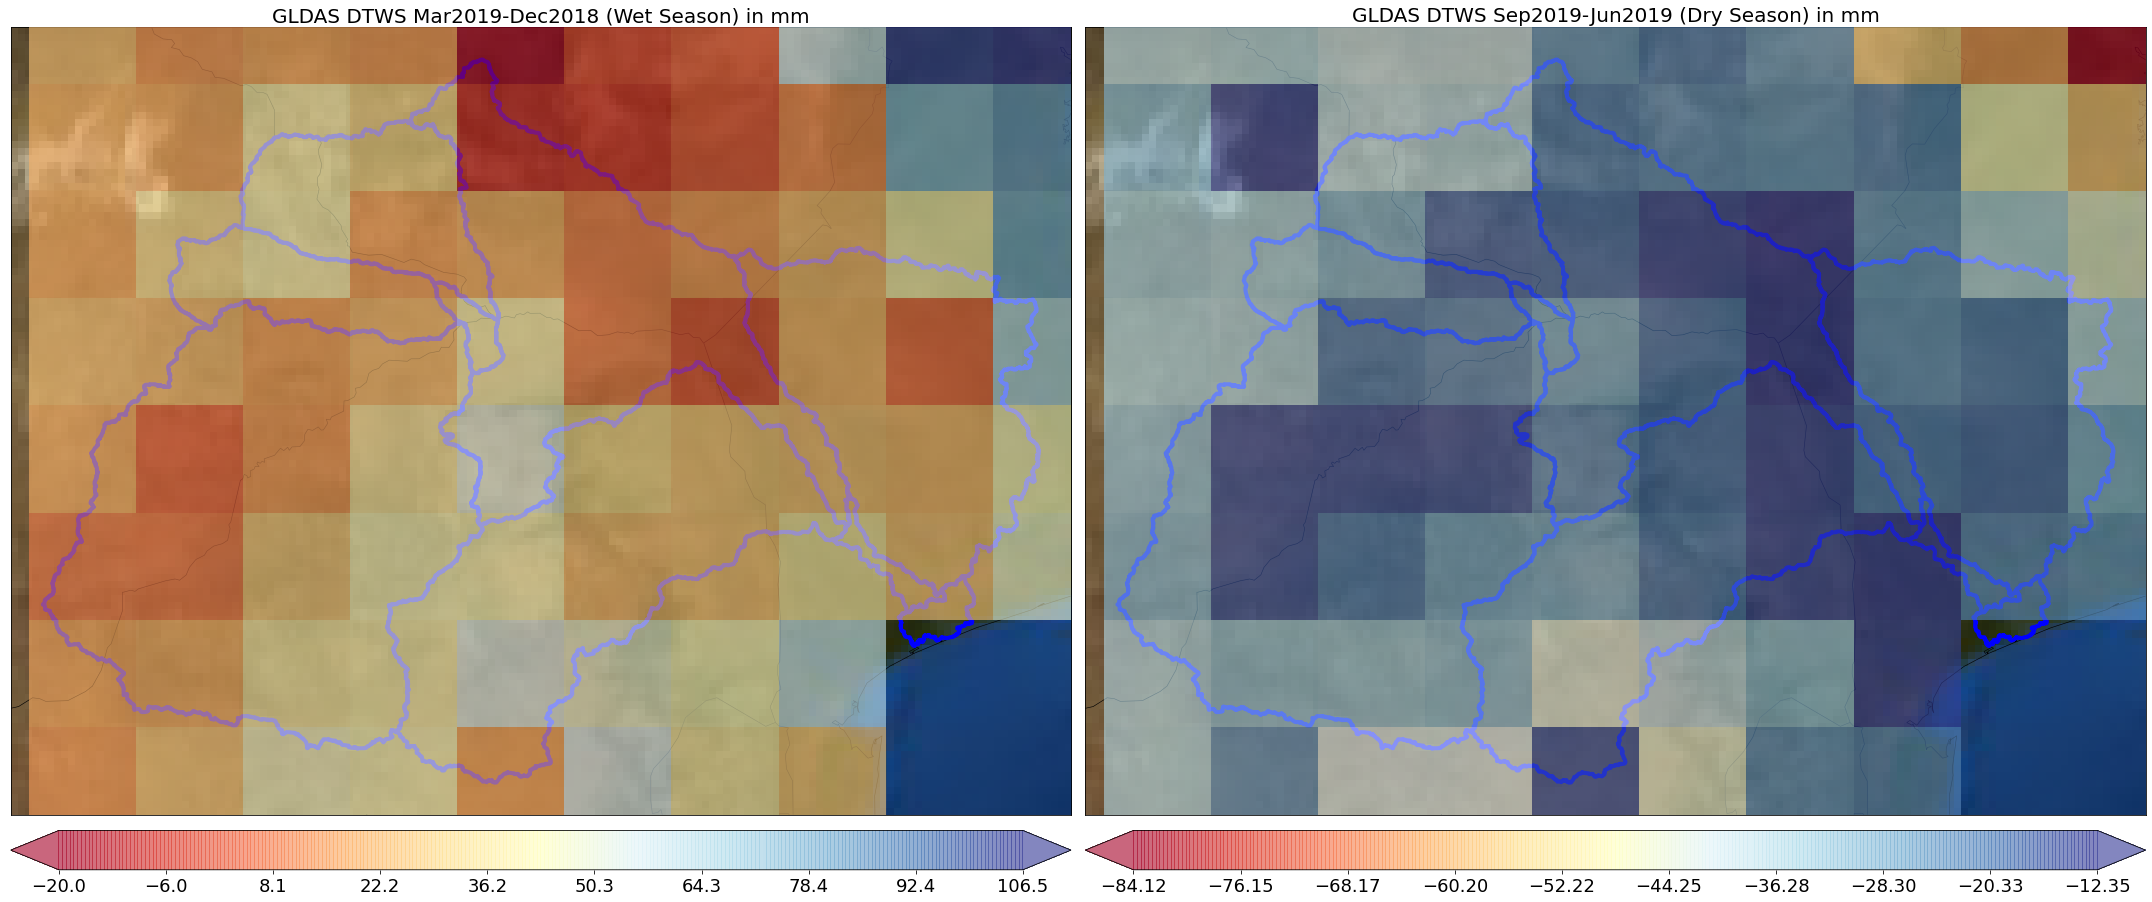

In [20]:
fig, axes = plt.subplots(1,2, figsize=(30,20))#(width,height)
fig.subplots_adjust(hspace=0, wspace=0.02)
axes = axes.ravel()

for i, ax in enumerate(axes):

  if i == 0:
    vmin = np.nanmin(DTWS_wet19)
    vmax = np.nanmax(DTWS_wet19)
    data_plot = ma.masked_where(DTWS_wet19 == np.nan, DTWS_wet19)
    title_name = 'GLDAS DTWS Mar2019-Dec2018 (Wet Season) in mm'
  elif i == 1:
    vmin = np.nanmin(DTWS_dry19)
    vmax = np.nanmax(DTWS_dry19)
    data_plot = ma.masked_where(DTWS_dry19 == np.nan, DTWS_dry19)
    title_name = 'GLDAS DTWS Sep2019-Jun2019 (Dry Season) in mm'  

  n_add = 0.3 # for zooming in and out
  m = Basemap(ax = axes[i],llcrnrlon=bbox_extent[0]-n_add,llcrnrlat=bbox_extent[1]-n_add,urcrnrlon=bbox_extent[2]+n_add,\
            urcrnrlat=bbox_extent[3]+n_add,resolution='i', projection='cyl')
  m.bluemarble()
  m.drawcoastlines(color='black',linewidth=0.6)
  m.drawcountries(color='black',linewidth=0.6)
  m.drawstates(color='black',linewidth=0.2)   

  im = axes[i].imshow(data_plot, extent=(left, right, bottom, top),vmin=vmin, vmax=vmax,cmap = 'RdYlBu', zorder=10, alpha=0.6)
  m.readshapefile('./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04', \
                'Limpopo_River_Sub-basins_lev04',linewidth=4, color='b',drawbounds=True)
  ax.set_title(title_name,fontsize=20) 
  
  divider = make_axes_locatable(ax)
  ticks = np.linspace(vmin, vmax, 10)
  cax = divider.append_axes("bottom", size="5%", pad="2%")
  cb = fig.colorbar(im, ax=ax,extend='both', cax=cax, orientation="horizontal",ticks=ticks)
  cb.ax.tick_params(labelsize=18)
    
plt.tight_layout()  
plt.savefig('./output/fig_01_GLDAS_DTWS_Wet_Dry.png',dpi=50,bbox_inches='tight')
plt.show()

### 4. Runoff

In [21]:
RO_files = sorted([i for i in glob('./data/GLDAS_RO/*.{}'.format('tif'))])

#### Wet Season

In [22]:
RO_files_wet = list(map(RO_files.__getitem__, [1,3,2]))
RO_wet = np.empty((8, 10,3))
RO_wet[:] = np.nan
for i in range(3):
  dataset = rio.open(RO_files_wet[i])
  # Grab limits of image's extent
  left, bottom, right, top =  dataset.bounds
  # load the geotiff image, assign it a variable
  image = dataset.read(1)
  image[(image == -9999)] = np.nan
  if i == 0 or i == 1:
    month_days = 31
  else:
    month_days = 28
  image_mm = image * 8 * month_days
  RO_wet[:,:,i] = image_mm
  del image_mm
RO_wet19 = np.sum(RO_wet,axis = 2)

#### Dry Season

In [23]:
RO_files_dry = list(map(RO_files.__getitem__, [-1,-2,0]))
RO_dry = np.empty((8, 10,3))
RO_dry[:] = np.nan
for i in range(3):
  dataset = rio.open(RO_files_dry[i])
  # Grab limits of image's extent
  left, bottom, right, top =  dataset.bounds
  # load the geotiff image, assign it a variable
  image = dataset.read(1)
  image[(image == -9999)] = np.nan
  if i == 0:
    month_days = 30
  else:
    month_days = 31
  image_mm = image * 8 * month_days
  RO_dry[:,:,i] = image_mm
  del image_mm
RO_dry19 = np.sum(RO_dry,axis = 2)

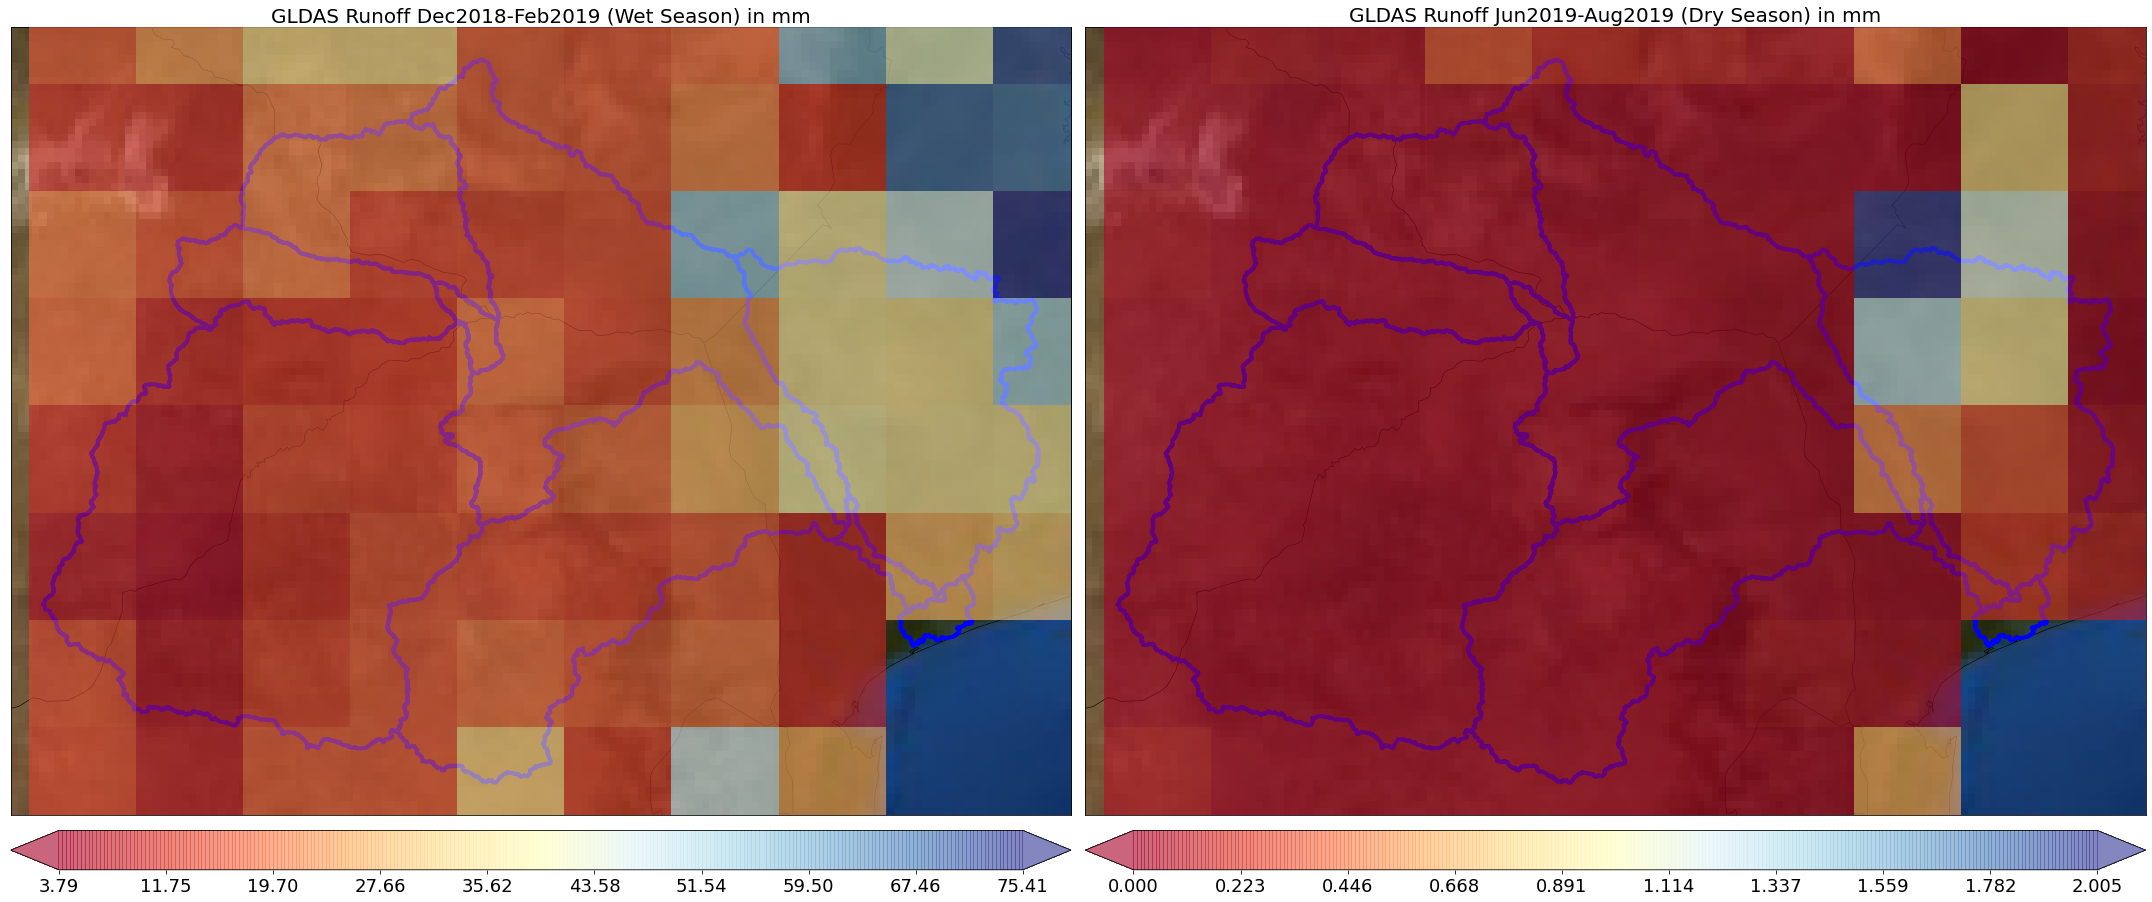

In [24]:
fig, axes = plt.subplots(1,2, figsize=(30,20))#(width,height)
fig.subplots_adjust(hspace=0, wspace=0.02)
axes = axes.ravel()

for i, ax in enumerate(axes):

  if i == 0:
    vmin = np.nanmin(RO_wet19)
    vmax = np.nanmax(RO_wet19)
    data_plot = ma.masked_where(RO_wet19 == np.nan, RO_wet19)
    title_name = 'GLDAS Runoff Dec2018-Feb2019 (Wet Season) in mm'
  elif i == 1:
    vmin = np.nanmin(RO_dry19)
    vmax = np.nanmax(RO_dry19)
    data_plot = ma.masked_where(RO_dry19 == np.nan, RO_dry19)
    title_name = 'GLDAS Runoff Jun2019-Aug2019 (Dry Season) in mm'  

  n_add = 0.3 # for zooming in and out
  m = Basemap(ax = axes[i],llcrnrlon=bbox_extent[0]-n_add,llcrnrlat=bbox_extent[1]-n_add,urcrnrlon=bbox_extent[2]+n_add,\
            urcrnrlat=bbox_extent[3]+n_add,resolution='i', projection='cyl')
  m.bluemarble()
  m.drawcoastlines(color='black',linewidth=0.6)
  m.drawcountries(color='black',linewidth=0.6)
  m.drawstates(color='black',linewidth=0.2)   

  im = axes[i].imshow(data_plot, extent=(left, right, bottom, top),vmin=vmin, vmax=vmax,cmap = 'RdYlBu', zorder=10, alpha=0.6)
  m.readshapefile('./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04', \
                'Limpopo_River_Sub-basins_lev04',linewidth=4, color='b',drawbounds=True)
  ax.set_title(title_name,fontsize=20) 
  
  divider = make_axes_locatable(ax)
  ticks = np.linspace(vmin, vmax, 10)
  cax = divider.append_axes("bottom", size="5%", pad="2%")
  cb = fig.colorbar(im, ax=ax,extend='both', cax=cax, orientation="horizontal",ticks=ticks)
  cb.ax.tick_params(labelsize=18)
    
plt.tight_layout()  
plt.savefig('./output/fig_01_GLDAS_Runoff_Wet_Dry.png',dpi=50,bbox_inches='tight')
plt.show()

### Zonal Statistics

#### Precipitation (PR)

In [25]:
### Wet Season
PR_wet = ma.masked_where(PR_wet19 == np.nan, PR_wet19)
PR_wet_dummy = rio.open(PR_files_wet[0])
PR_wet_affine = PR_wet_dummy.transform
zonal_stat_PR_wet = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 PR_wet,affine=PR_wet_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_PR_wet = zonal_stat_PR_wet.rename(columns={'mean': 'PRW Mean (mm)'})

### Dry Season
PR_dry = ma.masked_where(PR_dry19 == np.nan, PR_dry19)
PR_dry_dummy = rio.open(PR_files_dry[0])
PR_dry_affine = PR_dry_dummy.transform
zonal_stat_PR_dry = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 PR_dry,affine=PR_dry_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_PR_dry = zonal_stat_PR_dry.rename(columns={'mean': 'PRD Mean (mm)'})

/usr/local/lib/python3.6/dist-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


#### Evapotranspiration (ET)

In [26]:
### Wet Season
ET_wet = ma.masked_where(ET_wet19 == np.nan, ET_wet19)
ET_wet_dummy = rio.open(ET_files_wet[0])
ET_wet_affine = ET_wet_dummy.transform
zonal_stat_ET_wet = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 ET_wet,affine=ET_wet_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_ET_wet = zonal_stat_ET_wet.rename(columns={'mean': 'ETW Mean (mm)'})

### Dry Season
ET_dry = ma.masked_where(ET_dry19 == np.nan, ET_dry19)
ET_dry_dummy = rio.open(ET_files_dry[0])
ET_dry_affine = ET_dry_dummy.transform
zonal_stat_ET_dry = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 ET_dry,affine=ET_dry_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_ET_dry = zonal_stat_ET_dry.rename(columns={'mean': 'ETD Mean (mm)'})

/usr/local/lib/python3.6/dist-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


#### Difference Total Water Storage (DTWS)

In [27]:
### Wet Season
DTWS_wet = ma.masked_where(DTWS_wet19 == np.nan, DTWS_wet19)
DTWS_wet_dummy = rio.open(TWS_files[0])
DTWS_wet_affine = DTWS_wet_dummy.transform
zonal_stat_DTWS_wet = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 DTWS_wet,affine=DTWS_wet_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_DTWS_wet = zonal_stat_DTWS_wet.rename(columns={'mean': 'DTWSW Mean (mm)'})

### Dry Season
DTWS_dry = ma.masked_where(DTWS_dry19 == np.nan, DTWS_dry19)
DTWS_dry_dummy = rio.open(TWS_files[0])
DTWS_dry_affine = DTWS_dry_dummy.transform
zonal_stat_DTWS_dry = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 DTWS_dry,affine=DTWS_dry_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_DTWS_dry = zonal_stat_DTWS_dry.rename(columns={'mean': 'DTWSD Mean (mm)'})

/usr/local/lib/python3.6/dist-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


#### Runoff (RO)

In [28]:
### Wet Season
RO_wet = ma.masked_where(RO_wet19 == np.nan, RO_wet19)
RO_wet_dummy = rio.open(RO_files_wet[0])
RO_wet_affine = RO_wet_dummy.transform
zonal_stat_RO_wet = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 RO_wet,affine=RO_wet_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_RO_wet = zonal_stat_RO_wet.rename(columns={'mean': 'ROW Mean (mm)'})

### Dry Season
RO_dry = ma.masked_where(RO_dry19 == np.nan, RO_dry19)
RO_dry_dummy = rio.open(RO_files_dry[0])
RO_dry_affine = DTWS_dry_dummy.transform
zonal_stat_RO_dry = pd.DataFrame(zonal_stats("./data/Limpopo_Shapefile_w_SubBasins/Limpopo_River_Sub-basins_lev04.shp",\
                                 RO_dry,affine=RO_dry_affine, stats=['mean'],all_touched=True,geojson_out=False))
df_zonal_stat_RO_dry = zonal_stat_RO_dry.rename(columns={'mean': 'ROD Mean (mm)'})

/usr/local/lib/python3.6/dist-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


### Merging Zonal Statistics into Geopandas Dataframe

In [29]:
### Merging all dataframes
df = pd.concat([gpd_shapefile,df_zonal_stat_PR_wet, df_zonal_stat_PR_dry,\
                              df_zonal_stat_ET_wet,df_zonal_stat_ET_dry,\
                              df_zonal_stat_DTWS_wet,df_zonal_stat_DTWS_dry,\
                            df_zonal_stat_RO_wet,df_zonal_stat_RO_dry], axis=1, sort=False)

df_copy = df.copy()
df_copy = df_copy.to_crs("EPSG:6933") # epsg 6933. It is cylindrical equal-area projection

df_copy["Area (sqm)"] = df_copy['geometry'].area  

df_copy["PRW (cum)"] = df_copy["PRW Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["PRD (cum)"] = df_copy["PRD Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["ETW (cum)"] = df_copy["ETW Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["ETD (cum)"] = df_copy["ETD Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["TWSW (cum)"] = df_copy["DTWSW Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["TWSD (cum)"] = df_copy["DTWSD Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["ROW (cum)"] = df_copy["ROW Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy["ROD (cum)"] = df_copy["ROD Mean (mm)"] * df_copy["Area (sqm)"] * 0.001
df_copy.to_csv("./output/Limpopo_GLDAS.csv",index=False, encoding='utf-8-sig')

In [30]:
pd.options.display.max_columns = None
display(df_copy)

HYBAS_ID   NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  1040012590           0  1040012590  1040012590        0.0        0.0   
1  1041584690  1040012590  1040012590  1040012590       97.0       97.0   
2  1041584780  1040012590  1040012590  1040012590       97.2       97.2   
3  1041576130  1041584780  1040012590  1040012590      258.7      258.7   
4  1041576090  1041584780  1040012590  1040012590      258.9      258.9   
5  1041548260  1041576090  1040012590  1040012590      788.8      788.8   
6  1041548220  1041576090  1040012590  1040012590      789.0      789.0   
7  1041548760  1041548260  1040012590  1040012590      828.1      828.1   
8  1041548750  1041548260  1040012590  1040012590      828.3      828.3   

   SUB_AREA   UP_AREA  PFAF_ID  ENDO  COAST  ORDER  SORT   PEWcount  \
0    2666.7  407139.0     1241     0      0      1    40   0.139966   
1   64544.4   64544.4     1242     0      0      2    41   4.000000   
2    2422.9  345110.5     1243     0      0      1    42   0.215343   
3   81485.4   81485.7     1244     0      0      2    43   5.000000   
4   77221.4  261202.8     1245     0      0      1    44   8.000000   
5    2565.2  155088.5     1247     0      0      1    45   0.224211   
6   29066.7   29066.7     1246     0      0      2    46   4.000000   
7  133110.8  133110.8     1249     0      0      1    47  13.000000   
8   19497.6   19497.6     1248     0      0      2    48   1.699644   

       PEWsum    PEWmean          Area  \
0    8.450522  60.375423  2.947817e+09   
1  271.491245  67.872811  7.023703e+10   
2   12.953776  60.154166  2.668536e+09   
3  359.419754  71.883951  8.976130e+10   
4  451.838230  56.479779  8.353545e+10   
5   15.170820  67.663155  2.778429e+09   
6  297.376728  74.344182  3.122996e+10   
7  672.616299  51.739715  1.461870e+11   
8  107.515039  63.257390  2.106204e+10   

                                            geometry  PRW Mean (mm)  \
0  POLYGON ((3256353.200 -3051640.451, 3256357.22...     257.904648   
1  POLYGON ((3049496.124 -2693864.766, 3049602.40...     318.781000   
2  POLYGON ((3202540.452 -3083343.832, 3202540.45...     277.747831   
3  POLYGON ((3135804.108 -3004375.346, 3135804.10...     314.308792   
4  POLYGON ((2825590.379 -2476707.381, 2825787.19...     301.279637   
5  POLYGON ((2837902.718 -2799512.348, 2837936.80...     275.925061   
6  POLYGON ((2604325.514 -2660685.912, 2604270.77...     308.764469   
7  POLYGON ((2743024.542 -3212254.031, 2742622.51...     271.611508   
8  POLYGON ((2575940.573 -2772351.664, 2575863.76...     281.453813   

   PRD Mean (mm)  ETW Mean (mm)  ETD Mean (mm)  DTWSW Mean (mm)  \
0      12.015305     197.529224      38.848786        24.729736   
1      14.660534     235.549702      40.657456        32.048865   
2      11.865588     211.624210      34.041120        28.635457   
3       5.295241     245.144947      31.815980        32.301765   
4       7.687196     239.275973      30.307781        19.686331   
5       4.168867     216.679983      28.707547        25.289322   
6       4.476727     247.115433      31.783346        25.450663   
7       1.195785     215.142098      31.160020        28.187876   
8       2.536876     221.166683      31.670745        27.876491   

   DTWSD Mean (mm)  ROW Mean (mm)  ROD Mean (mm)    Area (sqm)     PRW (cum)  \
0       -22.240631      26.860313       0.207352  2.661081e+09  6.863052e+08   
1       -24.140191      38.166828       0.474141  6.438675e+10  2.052527e+10   
2       -18.614573      24.538820       0.237082  2.417664e+09  6.715008e+08   
3       -23.887482      18.778336       0.035531  8.130868e+10  2.555603e+10   
4       -21.469629      21.729412       0.129138  7.702232e+10  2.320526e+10   
5       -21.974747      14.037408       0.006535  2.558705e+09  7.060108e+08   
6       -26.203142      16.306468       0.008736  2.898728e+10  8.950242e+09   
7       -27.493764      12.120179       0.002252  1.328130e+11  3.607355e+10   
8       -26.756683  

### Calculating Seasonal Water Budget Components in BCM

In [31]:
PRW_Basin_BCM = sum(df_copy["PRW (cum)"].to_numpy()) * (10 ** -9) 
PRD_Basin_BCM = sum(df_copy["PRD (cum)"].to_numpy()) * (10 ** -9)
ETW_Basin_BCM = sum(df_copy["ETW (cum)"].to_numpy()) * (10 ** -9)
ETD_Basin_BCM = sum(df_copy["ETD (cum)"].to_numpy()) * (10 ** -9)
TWSW_Basin_BCM = sum(df_copy["TWSW (cum)"].to_numpy()) * (10 ** -9)
TWSD_Basin_BCM = sum(df_copy["TWSD (cum)"].to_numpy()) * (10 ** -9)
ROW_Basin_BCM = sum(df_copy["ROW (cum)"].to_numpy()) * (10 ** -9)
ROD_Basin_BCM = sum(df_copy["ROD (cum)"].to_numpy()) * (10 ** -9)

#### Water budget of whole basin in BCM

| PRW | PRD | ETW | ETD | TWSW | TWSD | ROW | ROD |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 121.848 | 2.376 | 95.158 | 13.474 | 11.474 | -10.242 | 8.176 | 0.045 |

### Examine Seasonal Water Budget Components

In [32]:
PR_ET_TWS_Wet_Season = PRW_Basin_BCM - ETW_Basin_BCM - TWSW_Basin_BCM
PR_ET_TWS_Dry_Season = PRD_Basin_BCM - ETD_Basin_BCM - TWSD_Basin_BCM
PR_ET_TWS_RO_Wet_Season = PRW_Basin_BCM - ETW_Basin_BCM - TWSW_Basin_BCM - ROW_Basin_BCM
PR_ET_TWS_RO_Dry_Season = PRD_Basin_BCM - ETD_Basin_BCM - TWSD_Basin_BCM - ROD_Basin_BCM

#### Water budget for wet and dry seasons

$$
Wet \:Season: PRW - ETW - TWSW = 15.260160 \:BCM
$$

$$
Dry \:Season: PRD - ETD - TWSD = -0.856022 \:BCM
$$

$$
Wet \:Season: PRW - ETW - TWSW - ROW = 7.084151 \:BCM
$$

$$
Dry \:Season: PRD - ETD - TWSD - ROD = -0.901153 \:BCM
$$